In [32]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import describe

import matplotlib.colors as colors

from scipy import signal

from scipy.stats import probplot
from scipy.stats import normaltest

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
from ML_Train.CNN_Classifier import  build_classifier_from_vae, create_vae, create_classifier
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [33]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [34]:
a = np.array([[1,2,3]])
np.repeat(a,3,axis=1).reshape(3,3)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [35]:
def extract_features(values,
                     scaler,
                     pca,
                     maxfft=-1,
                     train=False):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
#     amps /= 0.01
    amps = lin_log_interp(amps)
    
    _,minmax,mean,variance,skewness,kurtosis = describe(values,axis=1)
    mean = mean[...,np.newaxis]
    variance = variance[...,np.newaxis]
    skewness = skewness[...,np.newaxis]
    kurtosis = kurtosis[...,np.newaxis]
    
    sampleRMS = np.sqrt(1 / values.shape[0] * np.sum((values - np.repeat(mean,values.shape[1],axis=1).reshape(mean.shape[0],values.shape[1]))**2,axis=1))
    
    sampleRMS = sampleRMS[...,np.newaxis]
    
    print(mean.shape,variance.shape,skewness.shape,kurtosis.shape,sampleRMS.shape)
    

    stats = np.hstack((mean,variance,skewness,kurtosis,sampleRMS))
    
    if train:
        stats = scaler.fit_transform(stats)
        X = np.hstack((amps[:,:maxfft],stats))
#         X_pca = pca.fit_transform(X)
    else:
        stats = scaler.transform(stats)
        X = np.hstack((amps[:,:maxfft],stats))
#         X_pca = pca.transform(X)      
    
    
    return amps[:,:maxfft],stats


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [36]:
DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

In [37]:
samples_train = np.loadtxt('Experiment-3-Data/Samples_train.txt',delimiter=',')
samples_test = np.loadtxt('Experiment-3-Data/Samples_test.txt',delimiter=',')
args_test = np.loadtxt('Experiment-3-Data/Pruned_args_test.txt',delimiter=',')
print(args_test)

[  1.   2.   3.   4.   5.   6.   7.   9.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  35.  36.  37.  38.  39.  40.  41.  43.  44.  45.  46.  47.  48.  49.
  50.  51.  52.  53.  56.  57.  58.  59.  60.  61.  62.  65.  66.  67.
  68.  69.  70.  71.  72.  75.  76.  77.  78.  81.  82.  83.  96.  97.
  98.  99. 101. 102. 103. 104. 105. 106. 107. 108. 110. 111. 112. 113.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 127. 128. 129.
 130. 131. 132. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 158. 159. 160.
 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.]


In [164]:
max_fft = 256
DoE_shape = 1

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

print(X_test.shape)

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

pca = PCA()
scaler = StandardScaler()

X_train_original,stats_train_original = extract_features(X_train,scaler,pca,max_fft,train=True)
X_test_original,stats_test_original = extract_features(X_test,scaler,pca,max_fft)

stats_train_original = np.hstack((stats_train_original,DoE_train))
stats_test_original = np.hstack((stats_test_original,DoE_test))

X_train_original = np.hstack((X_train_original,DoE_train))
X_test_original = np.hstack((X_test_original,DoE_test))

X_train_healthy = X_train_original[first_good_train:,:]
X_valid_healthy = X_test_original[first_good_test:,:]
X_train_unhealthy = X_train_original[:first_good_train,:]
X_valid_unhealthy = X_test_original[:first_good_test,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

np.random.shuffle(XY_train)
np.random.shuffle(XY_valid)

X_train = XY_train[:,:max_fft + DoE_shape]
Y_train = XY_train[:,-1]

X_valid = XY_valid[:,:max_fft + DoE_shape]
Y_valid = XY_valid[:,-1]
columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']


(151, 4200)
(306, 1) (306, 1) (306, 1) (306, 1) (306, 1)
(151, 1) (151, 1) (151, 1) (151, 1) (151, 1)


In [165]:
print(X_valid_healthy.shape)
print(X_valid_unhealthy.shape)

print(86 / (86 + 65))
print(65 / (86 + 65))

(86, 259)
(65, 259)
0.5695364238410596
0.4304635761589404


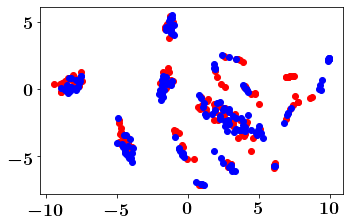

In [166]:
pca = PCA(n_components=5)
scaler = StandardScaler()

tsne_train = scaler.fit_transform(stats_train_original)
tsne_test = scaler.transform(stats_test_original)
tsne_train_pca = pca.fit_transform(tsne_train)
tsne_test_pca = pca.transform(tsne_test)
tsne = TSNE(n_components=2,perplexity=75)
Y = tsne.fit_transform(tsne_train_pca)
# Y_test = tsne.transform(X_test_pca)


plt.scatter(Y[first_good_train:, 0], Y[first_good_train:, 1], c="r")
plt.scatter(Y[:first_good_train, 0], Y[:first_good_train, 1], c="b")
plt.show()

# plt.scatter(Y[first_good_train:, 0], Y[first_good_train:, 1], c="r")
# plt.scatter(Y_test[:first_good_test, 0], Y_test[:first_good_test, 1], c="b")
# plt.show()

In [167]:
def fit_statistics(y_true, y_pred):

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall
 

def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # It is better to investigate something and conclude it is healthy
    # than let an unhealthy tool go unnoticed. For this reason, false
    # positives are considered less costly than false negatives
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='gray',norm=colors.Normalize(vmin=0.,vmax=.5))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ylabel = 'Actual State'
    xlabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text_color = 'w'
            if conf_matrix[i,j] > 0.25:
                text_color = 'k'
            text = ax.text(j, i, r'\textbf{' + str(conf_matrix[i, j]) + '}',fontsize=22,
                           ha="center", va="center", color=text_color)

    cbar = plt.colorbar(im)
    cbar.set_label(r'\textbf{Occurrence Fraction}', rotation=270,labelpad=20)
    plt.tight_layout()
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall

In [168]:
precision_recall = np.zeros((62,4))
precision_recall_columns = ['Train Precision','Train Recall','Valid Precision','Valid Recall']

for i in range(2,64):
    
    estimators = [('scaler',StandardScaler()), ('reduce_dim', PCA(n_components=i)), ('gnb', GaussianNB())]
#     estimators = [('scaler',StandardScaler()), ('reduce_dim', PCA(n_components=i)), ('Gauss_Process', GaussianProcessClassifier(1.0 * RBF(1.0)))]

    pipe = Pipeline(estimators)
    pipe.fit(X_train,Y_train)
    Y_valid_pred = pipe.predict(X_valid)
    Y_train_pred = pipe.predict(X_train)

    fit_train = fit_statistics(Y_train, Y_train_pred)
    fit_valid = fit_statistics(Y_valid, Y_valid_pred)

    precision_recall[i-2,:] = np.array([fit_train[-2],fit_train[-1],fit_valid[-2],fit_valid[-1]])


precision_recall_stats = np.zeros((62,4))

for i in range(2,8):
    
    estimators = [('scaler',StandardScaler()), ('reduce_dim', PCA(n_components=i)), ('gnb', GaussianNB())]
#     estimators = [('scaler',StandardScaler()), ('reduce_dim', PCA(n_components=i)), ('Gauss_Process', GaussianProcessClassifier(1.0 * RBF(1.0)))]

    pipe = Pipeline(estimators)
    pipe.fit(stats_train_original,Y_train)
    Y_valid_pred = pipe.predict(stats_test_original)
    Y_train_pred = pipe.predict(stats_train_original)

    fit_train = fit_statistics(Y_train, Y_train_pred)
    fit_valid = fit_statistics(Y_valid, Y_valid_pred)

    precision_recall_stats[i-2,:] = np.array([fit_train[-2],fit_train[-1],fit_valid[-2],fit_valid[-1]])


In [169]:
print(np.argmax(precision_recall[:,2]))
print(np.argmax(precision_recall[:,3]))
print(precision_recall[np.argmax(precision_recall[:,2]),:])
print(precision_recall[np.argmax(precision_recall[:,3]),:])

print(np.argmax(precision_recall_stats[:,2]))
print(np.argmax(precision_recall_stats[:,3]))
print(precision_recall_stats[np.argmax(precision_recall_stats[:,2]),:])
print(precision_recall_stats[np.argmax(precision_recall_stats[:,3]),:])

19
9
[0.98039216 0.98039216 0.81395349 0.74468085]
[0.96078431 0.96078431 0.76744186 0.97058824]
5
0
[0.94117647 0.52747253 0.93023256 0.42105263]
[0.92156863 0.52222222 0.88372093 0.45783133]


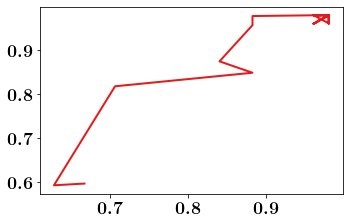

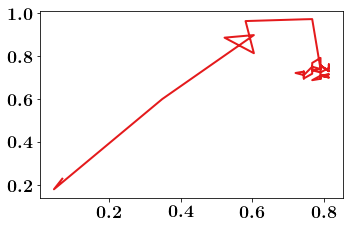

In [170]:
plt.plot(precision_recall[:,0],precision_recall[:,1])
plt.show()

plt.plot(precision_recall[:,2],precision_recall[:,3])
plt.show()

In [172]:
estimators = [('scaler',StandardScaler()), ('reduce_dim', PCA(n_components=9)), ('gnb', GaussianNB())]
# estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

pipe = Pipeline(estimators)
pipe.fit(X_train,Y_train)

Y_valid_pred = pipe.predict(X_valid)
conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

Y_train_pred = pipe.predict(X_train)
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)

dump(pipe, 'data/pca_gnb.joblib') 

[[38 27]
 [ 1 85]]
0.8145695364238411
[[139  17]
 [  4 146]]
0.9313725490196079


['data/pca_gnb.joblib']

In [173]:
samples_test.shape
X_test_original.shape
first_good_train

156

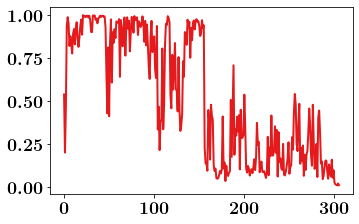

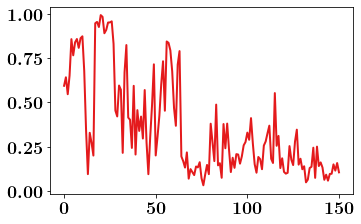

In [174]:
plt.plot(pipe.predict_proba(X_train_original[:,:max_fft + DoE_shape])[:,0])
plt.show()

plt.plot(pipe.predict_proba(X_test_original[:,:max_fft + DoE_shape])[:,0])
plt.show()

No handles with labels found to put in legend.


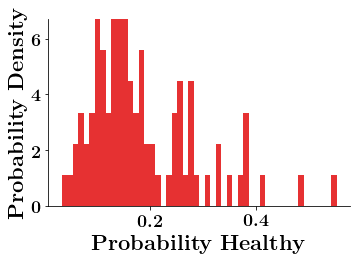

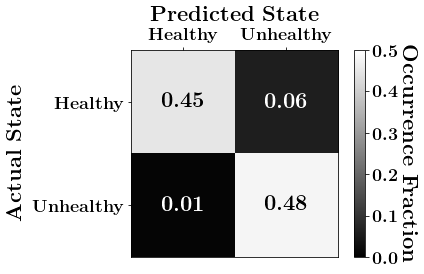

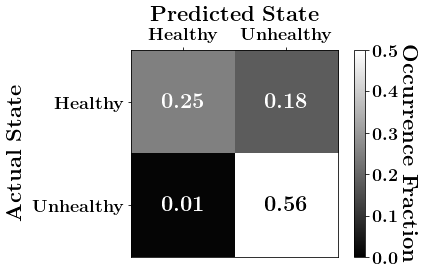

No handles with labels found to put in legend.


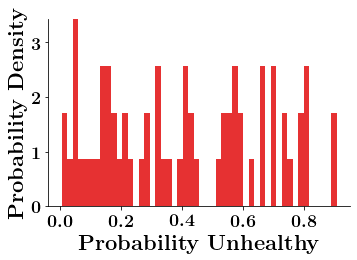

(0.9335748792270531, 0.9782608695652174, 0.8888888888888888, 0.8823529411764706, 0.9782608695652174)
(0.8591476091476091, 0.9615384615384615, 0.7567567567567568, 0.5813953488372093, 0.9615384615384615)


In [175]:
# pipe.predict_proba(X_train_healthy)[:,0]

responses= np.vstack((
                       pipe.predict_proba(X_valid_healthy[:,:max_fft + DoE_shape])[:,0]))
genplt.plot_histogram(responses,[''],
               'Probability Healthy',
               'Probability Density',
               'pca_gnb_predict_healthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_valid'
                       )

responses= np.vstack((
                       pipe.predict_proba(X_valid_unhealthy[:,:max_fft + DoE_shape])[:,1]))
genplt.plot_histogram(responses,[''],
               'Probability Unhealthy',
               'Probability Density',
               'pca_gnb_predict_unhealthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [22]:
def normalize_scores(scores,log_prob=False):
    
    if log_prob:
        scores = np.log(np.abs(scores - 1.1 * np.amax(scores)))
    
    norm_mean = np.mean(scores[:,0])
    norm_std = np.std(scores[:,0])
    
    scores = (scores - norm_mean) / norm_std
    
    [print(normaltest(scores[:,i])) for i in range(scores.shape[1])]
    [print(np.std(scores[:,i]), np.mean(scores[:,i])) for i in range(scores.shape[1])]
    
    return scores

In [23]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape,
                   dense_nodes,
                   classes,
                   ):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for i in range(len(filters)):
        x = Conv1D(filters=filters[i], 
                           kernel_size=kernels[i], 
                           strides=strides[i], 
                           activation='relu', 
                           padding='same',
                           dilation_rate=dilation_rates[i])(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(len(dense_nodes)):
        x = Dense(dense_nodes[i],activation='relu')(x)
        
    x = Dense(classes,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    return cnn_classifier

def create_classifier(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
    dense_nodes = param_dict["dense_nodes"]
    classes = param_dict["classes"]
    
    classifier = build_classifier(filters,kernels,strides,dilation_rates,input_shape,dense_nodes,classes)
 
    return classifier
        

In [25]:
train = True
if not train:
# if os.path.isfile('../../Models/MLP-Classifier/Full/CNN-MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('../../Models/MLP-Classifier/Full/CNN-MLP.h5')
    print(model.summary())
else:

    filters=[8,8,8]
    kernels = [3,3,3]
    strides=[1,1,1,1,1]
    dilation_rates=[1,1,1,1,1]
    input_shape = [128,1]
    dense_nodes = [64,32]
    codings_size = 2

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
        "dense_nodes":dense_nodes,
        "classes":2
    }
    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2
    model = create_classifier(param_dict)
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    loss = model.fit(
                X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
                validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                epochs=10,
                batch_size=8,
                verbose=1)
    
    print(model.summary())
    
    model.save('../../Models/MLP-Classifier/Full/CNN-MLP.h5',save_format='tf')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(os.path.join('../../Models/MLP-Classifier/Lite', 'CNN-MLP.tflite',),
     "wb").write(tflite_model)

Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])

Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - 2s 5ms/sample - loss: 0.8064 - accuracy: 0.5850 - val_loss: 0.7128 - val_accuracy: 0.4570
Epoch 2/10
306/306 [==============================] - 0s 671us/sample - loss: 0.7872 - accuracy: 0.5523 - val_loss: 0.7478 - val_accuracy: 0.4305
Epoch 3/10
306/306 [==============================] - 0s 643us/sample - loss: 0.7832 - accuracy: 0.5359 - val_loss: 0.7556 - val_accuracy: 0.4305
Epoch 4/10
306/306 [==============================] - 0s 681us/sample - loss: 0.7056 - accuracy: 0.5719 - val_loss: 0.7556 - val_accuracy: 0.4305
Epoch 5/10
306/306 [==============================] - 0s 676us/sample - loss: 0.7406 - accuracy: 0.5719 - val_loss: 0.7643 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - 0s 679us/sample - loss: 0.7081 - accuracy: 0.5784 - val_loss: 0.7765 - val_accuracy: 0.4305
Epoch 7/10
306/306 [==============================] - 0s 685us/sample - loss: 0.

In [26]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[63  2]
 [78  8]]
0.47019867549668876
[[155   1]
 [136  14]]
0.5522875816993464


No handles with labels found to put in legend.


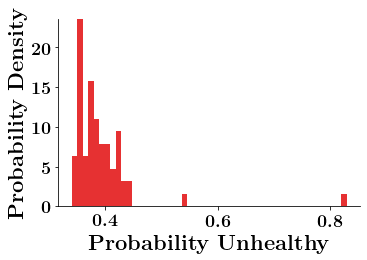

No handles with labels found to put in legend.


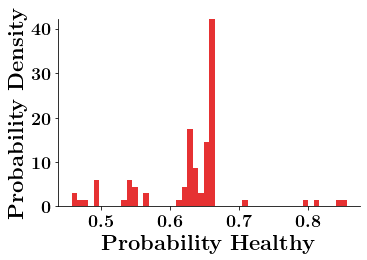

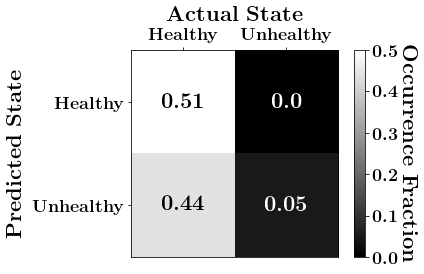

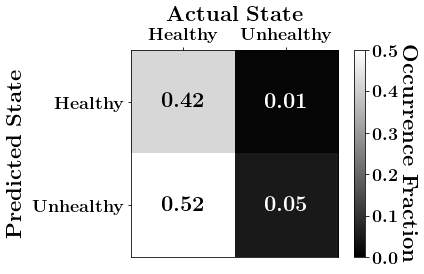

(0.7684210526315789, 0.5368421052631579, 1.0)
(0.6400709219858156, 0.4468085106382979, 0.8333333333333333)


In [28]:
genplt.plot_histogram(model.predict(X_valid_unhealthy[...,np.newaxis])[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'cnn_mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy[...,np.newaxis])[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'cnn_mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_cnn_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_cnn_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [29]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_mlp_classifier(
                   hidden_nodes,
                   input_shape,
                   classes,
                   ):
    
    mlp = Sequential()
    mlp.add(Input(shape=input_shape))
    mlp.add(Flatten())
    
    for i in range(len(hidden_nodes)):
        if i == 0:
            mlp.add(Dense(hidden_nodes[i], 
                              activation='selu'))
        else:
            mlp.add(Dense(hidden_nodes[i], activation='selu'))
            
    mlp.add(Dense(classes,activation='softmax'))
        
    return mlp

In [32]:

if not train:
# if os.path.isfile('../../Models/MLP-Classifier/Full/MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('../../Models/MLP-Classifier/Full/MLP.h5')
    print(model.summary())
else:
    input_shape = [128]
    dense_nodes = [64,32]

    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2

    model = create_mlp_classifier(dense_nodes,input_shape,num_classes)


    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    loss = model.fit(
                X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
                validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                epochs=10,
                batch_size=8,
                verbose=1)

    model.save('../../Models/MLP-Classifier/Full/MLP.h5',save_format='tf')


    
Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmax(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmax(Y_mlp_valid_pred,axis=1)

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - 0s 872us/sample - loss: 0.6137 - accuracy: 0.7418 - val_loss: 0.7685 - val_accuracy: 0.5166
Epoch 2/10
306/306 [==============================] - 0s 290us/sample - loss: 0.4423 - accuracy: 0.8758 - val_loss: 0.9944 - val_accuracy: 0.4834
Epoch 3/10
306/306 [==============================] - 0s 282us/sample - loss: 0.3259 - accuracy: 0.8791 - val_loss: 1.2269 - val_accuracy: 0.5298
Epoch 4/10
306/306 [==============================] - 0s 286us/sample - loss: 0.2432 - accuracy: 0.9314 - val_loss: 1.5543 - val_accuracy: 0.4901
Epoch 5/10
306/306 [==============================] - 0s 274us/sample - loss: 0.1951 - accuracy: 0.9444 - val_loss: 1.8212 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - 0s 284us/sample - loss: 0.1505 - accuracy: 0.9771 - val_loss: 2.0702 - val_accuracy: 0.5960
Epoch 7/10
306/306 [==============================] - 0s 283us/sample - loss: 

In [33]:
model.predict(X_valid)

array([[1.00000000e+00, 3.50356810e-12],
       [6.39411951e-07, 9.99999404e-01],
       [9.96952534e-01, 3.04745953e-03],
       [9.42267299e-01, 5.77327721e-02],
       [2.04141200e-01, 7.95858800e-01],
       [9.95607436e-01, 4.39259503e-03],
       [1.18526928e-01, 8.81473064e-01],
       [6.82603335e-04, 9.99317408e-01],
       [9.40434277e-01, 5.95657416e-02],
       [6.01318479e-01, 3.98681521e-01],
       [3.91460657e-02, 9.60853875e-01],
       [9.98917818e-01, 1.08223688e-03],
       [3.59958619e-01, 6.40041411e-01],
       [1.04593486e-01, 8.95406544e-01],
       [9.87380981e-01, 1.26189943e-02],
       [1.00000000e+00, 6.68071543e-19],
       [9.76205289e-01, 2.37947889e-02],
       [6.83421385e-05, 9.99931693e-01],
       [1.34092540e-01, 8.65907431e-01],
       [9.21957374e-01, 7.80425742e-02],
       [6.70415536e-02, 9.32958424e-01],
       [1.91465132e-02, 9.80853438e-01],
       [1.00000000e+00, 1.87140410e-13],
       [1.08358972e-01, 8.91641021e-01],
       [3.360048

No handles with labels found to put in legend.


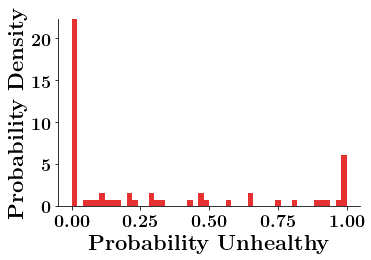

No handles with labels found to put in legend.


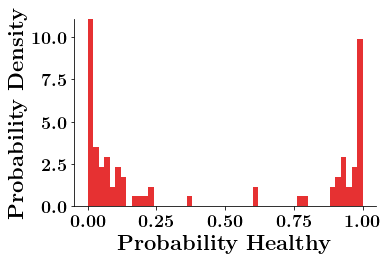

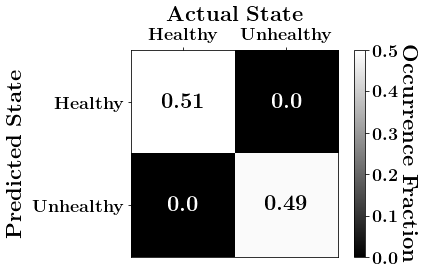

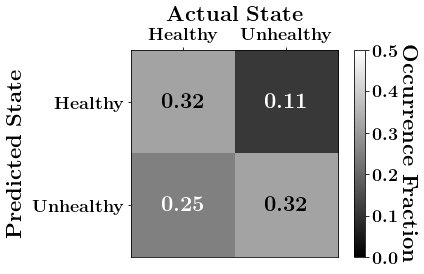

(1.0, 1.0, 1.0)
(0.6527947776417788, 0.5614035087719298, 0.7441860465116279)


In [34]:
genplt.plot_histogram(model.predict(X_valid_unhealthy)[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy)[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_mlp_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_mlp_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [35]:

conf_matrix_mlp_valid = confusion_matrix(Y_valid, Y_mlp_valid_pred)
accuracy_mlp_valid = np.sum(np.diagonal(conf_matrix_mlp_valid)) / np.sum(conf_matrix_mlp_valid)
print(conf_matrix_mlp_valid)
print(accuracy_mlp_valid)

conf_matrix_mlp_train = confusion_matrix(Y_train, Y_mlp_train_pred)
accuracy_mlp_train = np.sum(np.diagonal(conf_matrix_mlp_train)) / np.sum(conf_matrix_mlp_train)
print(conf_matrix_mlp_train)
print(accuracy_mlp_train)

[[48 17]
 [37 49]]
0.6423841059602649
[[156   0]
 [  0 150]]
1.0


In [10]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_mlp_classifier(
                   hidden_nodes,
                   input_shape,
                   classes,
                   ):
    
    mlp = Sequential()
    mlp.add(Input(shape=input_shape))
    mlp.add(Flatten())
    
    for i in range(len(hidden_nodes)):
        if i == 0:
            mlp.add(Dense(hidden_nodes[i], 
                              activation='selu'))
        else:
            mlp.add(Dense(hidden_nodes[i], activation='selu'))
            
    mlp.add(Dense(classes,activation='softmax'))
        
    return mlp

In [14]:
train = True
if not train:
# if os.path.isfile('../../Models/MLP-Classifier/Full/MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('../../Models/MLP-Classifier/Full/MLP.h5')
    print(model.summary())
else:
    input_shape = [128]
    dense_nodes = [64,32,16]

    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2

    model = create_mlp_classifier(dense_nodes,input_shape,num_classes)


    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    loss = model.fit(
                X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
                validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                epochs=20,
                batch_size=4,
                verbose=1)

    model.save('../../Models/MLP-Classifier/Full/MLP.h5',save_format='tf')


    
Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmax(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmax(Y_mlp_valid_pred,axis=1)

Train on 306 samples, validate on 151 samples
Epoch 1/20
306/306 [==============================] - 0s 1ms/sample - loss: 0.6941 - accuracy: 0.5261 - val_loss: 0.6893 - val_accuracy: 0.5695
Epoch 2/20
306/306 [==============================] - 0s 573us/sample - loss: 0.6849 - accuracy: 0.5588 - val_loss: 0.7025 - val_accuracy: 0.4570
Epoch 3/20
306/306 [==============================] - 0s 567us/sample - loss: 0.6737 - accuracy: 0.5654 - val_loss: 0.7093 - val_accuracy: 0.4636
Epoch 4/20
306/306 [==============================] - 0s 562us/sample - loss: 0.5941 - accuracy: 0.6928 - val_loss: 0.7706 - val_accuracy: 0.5364
Epoch 5/20
306/306 [==============================] - 0s 563us/sample - loss: 0.4716 - accuracy: 0.8007 - val_loss: 1.0116 - val_accuracy: 0.5232
Epoch 6/20
306/306 [==============================] - 0s 562us/sample - loss: 0.4031 - accuracy: 0.8007 - val_loss: 1.4541 - val_accuracy: 0.4702
Epoch 7/20
306/306 [==============================] - 0s 557us/sample - loss: 0.